In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets, transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset


In [2]:
def flatten(x):
    return x.view(-1)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(flatten)
    ])

train_data = datasets.MNIST(
        root= './data',
        train = True,
        download= True,
        transform= transform
    )


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.6MB/s]


In [3]:
!nvidia-smi

Sat Jan 31 12:01:27 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
test_data = datasets.MNIST(
    root = './data',
    train=False,
    download = True,
    transform = transform)

In [5]:
print(torch.version.cuda)

12.6


In [6]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
train_data[0][0].shape

torch.Size([784])

In [8]:
class NN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 10)
            )

    def forward(self, x):
        return self.model(x)


In [9]:
train_loader = DataLoader(batch_size=64, dataset= train_data, shuffle= True, pin_memory= True, num_workers= 0)
test_loader = DataLoader(batch_size=64, dataset= test_data, shuffle= False, pin_memory= True, num_workers= 0)

In [10]:
model = NN(*train_data[0][0].shape) #just a fancy way of passing 784 lol
model.to(device)

NN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [11]:
!pip install torchinfo
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
NN                                       --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       200,960
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       32,896
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       8,256
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       650
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0

In [12]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# nestrov tbd
# optimizer = optim.Adagrad(model.parameters(), lr=0.01)
# optimizer = optim.RMSprop(model.parameters(), lr=0.00)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
epochs = 100
epoch_losses = []
model.train()
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_label in train_loader:
        batch_features, batch_label = batch_features.to(device, non_blocking = True), batch_label.to(device, non_blocking=True )
        output = model(batch_features)

        loss = criterion(output, batch_label)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_epoch_loss += loss.item()
    avg_loss = total_epoch_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch - {epoch+1} | Loss - {avg_loss}")


Epoch - 1 | Loss - 0.3143140001258235
Epoch - 2 | Loss - 0.1122363331322588
Epoch - 3 | Loss - 0.07628558131246599
Epoch - 4 | Loss - 0.05597914242843933
Epoch - 5 | Loss - 0.042509770887131405
Epoch - 6 | Loss - 0.0337155690104991
Epoch - 7 | Loss - 0.028001117144011583
Epoch - 8 | Loss - 0.023628320639638645
Epoch - 9 | Loss - 0.019085168907413137
Epoch - 10 | Loss - 0.019597650804052368
Epoch - 11 | Loss - 0.01630248268528614
Epoch - 12 | Loss - 0.013687145323572947
Epoch - 13 | Loss - 0.012172292460527853
Epoch - 14 | Loss - 0.011006783799697982
Epoch - 15 | Loss - 0.014923418806054576
Epoch - 16 | Loss - 0.009838535635697317
Epoch - 17 | Loss - 0.012750234648965896
Epoch - 18 | Loss - 0.008630707345834682
Epoch - 19 | Loss - 0.007374454481852783
Epoch - 20 | Loss - 0.012077676934356787
Epoch - 21 | Loss - 0.0077623943658278296
Epoch - 22 | Loss - 0.008313733033347603
Epoch - 23 | Loss - 0.00743286286992654
Epoch - 24 | Loss - 0.007803435355234892
Epoch - 25 | Loss - 0.005085967861

KeyboardInterrupt: 

In [ ]:
total = 0
correct = 0

with torch.inference_mode():

    for batch_fea, batch_lab in train_loader:
        batch_fea, batch_lab = batch_fea.to(device), batch_lab.to(device)

        outputs = model(batch_fea)

        _, predicted = torch.max(outputs, 1)

        total += batch_lab.shape[0]

        correct += (predicted == batch_lab).sum().item()

    print(correct/total)

0.9995


In [ ]:
total = 0
correct = 0

with torch.inference_mode():

    for batch_fea, batch_lab in test_loader:
        batch_fea, batch_lab = batch_fea.to(device), batch_lab.to(device)

        outputs = model(batch_fea)

        _, predicted = torch.max(outputs, 1)

        total += batch_lab.shape[0]

        correct += (predicted == batch_lab).sum().item()

    print(correct/total)

0.9847


Text(0, 0.5, 'loss')

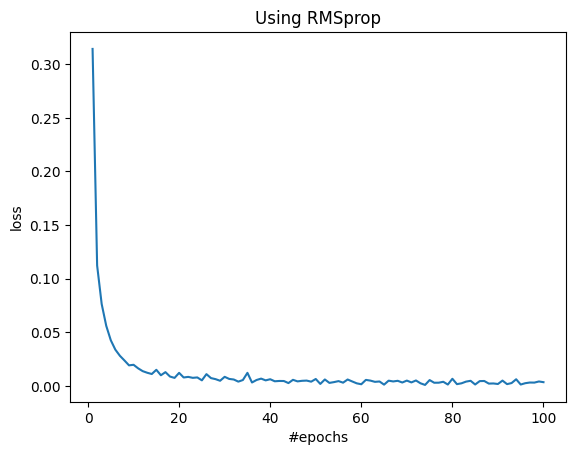

In [ ]:
plt.figure()
plt.plot(range(1, epochs+1,), epoch_losses)
plt.title("Using RMSprop")
plt.xlabel("#epochs")
plt.ylabel("loss")